In [1]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import VotingRegressor
from alpha_vantage.timeseries import TimeSeries


In [2]:
import pandas as pd
from datetime import datetime
import yfinance
import matplotlib.pyplot as plt
from alpha_vantage.timeseries import TimeSeries


def get_historical(quote):
    end = datetime.now()
    start = datetime(end.year - 2, end.month, end.day)
    data = yfinance.download(quote, start=start, end=end)
    df = pd.DataFrame(data=data)
    file_name=quote+".csv"
    df.to_csv(file_name)
    if df.empty:
        ts = TimeSeries(key="dj0yJmk9WVJxNlRuYlZ3TXVjJmQ9WVdrOU1HSTNaMDVFZUZrbWNHbzlNQT09JnM9Y29uc3VtZXJzZWNyZXQmc3Y9MCZ4PWQ1", output_format="pandas")
        data= ts.get_daily_adjusted(symbol="NSE:" + quote, outputsize="full")
        data = data.head(503).iloc[::-1]
        data = data.reset_index()
        df = pd.DataFrame()
        df["Date"] = data["date"]
        df["Open"] = data["1. open"]
        df["High"] = data["2. high"]
        df["Low"] = data["3. low"]
        df["Close"] = data["4. close"]
        df["Adj Close"] = data["5. adjusted close"]
        df["Volume"] = data["6. volume"]
        file_name = quote + ".csv"
        df.to_csv(file_name, index=False)
    return file_name

In [3]:
nm = input()
print(nm)
file = get_historical(nm)
# df=pd.read_csv(file)
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
data = pd.read_csv(file, sep=',', parse_dates=['Date'], index_col='Date', date_parser=dateparse)
plt.figure(figsize=(5,5))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Open Prices')
plt.plot(data['Open'])

[*********************100%%**********************]  1 of 1 completed


In [5]:
#splitting the data into 70% training and 30% testing
train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]
# plt.figure(figsize=(5,5))
# plt.grid(True)
# plt.xlabel('Dates')
# plt.ylabel('Open Prices')
# plt.plot(data['Open'], 'green', label='Train data')
# plt.plot(test_data['Open'], 'blue', label='Test data')
# plt.legend()

In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
# preprocessing training data
train = train_data.iloc[:, 0:1].values 
scaler = MinMaxScaler() 
train_scaled = scaler.fit_transform(train)
timesteps = 7
X_train = []
y_train = []
for i in range(timesteps, train.shape[0]):
    X_train.append(train_scaled[i-timesteps:i, 0]) 
    y_train.append(train_scaled[i, 0]) 
X_train, y_train = np.array(X_train), np.array(y_train)

In [8]:
#preprocessing testing data
test = test_data.iloc[:, 0:1].values 
scaler = MinMaxScaler() 
test_scaled = scaler.fit_transform(test)
timesteps = 7
X_test = []
y_test = []
for i in range(timesteps, test.shape[0]):
    X_test.append(test_scaled[i-timesteps:i, 0]) 
    y_test.append(test_scaled[i, 0]) 
X_test, y_test = np.array(X_test), np.array(y_test)

In [8]:
regressor1 = RandomForestRegressor()
regressor2 = GradientBoostingRegressor()
regressor3 = LinearRegression()

# Create a voting regressor
voting_regressor = VotingRegressor(estimators=[('rf', regressor1), ('gb', regressor2), ('lr', regressor3)])

# Fit the ensemble model
voting_regressor.fit(X_train, y_train)

VotingRegressor(estimators=[('rf', RandomForestRegressor()),
                            ('gb', GradientBoostingRegressor()),
                            ('lr', LinearRegression())])

predicted stock price for tomorrow:  [169.97742629]


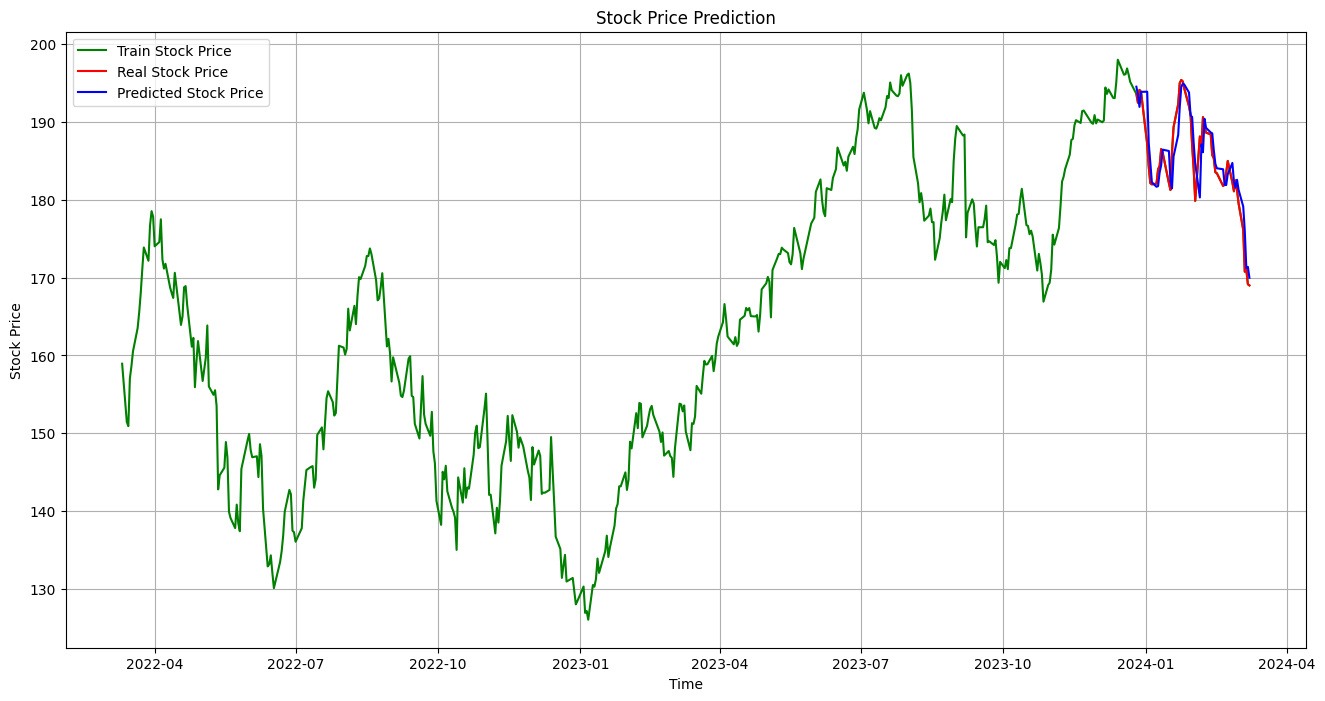

In [9]:
real_stock_price = test_data.iloc[:, 0:1].values
combine = pd.concat((train_data['Open'], test_data['Open']), axis=0)

test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
test_inputs = test_inputs.reshape(-1, 1)
test_inputs = scaler.transform(test_inputs)
X_test = []
for i in range(timesteps, test_data.shape[0] + timesteps):
    X_test.append(test_inputs[i - timesteps:i, 0])

X_test = np.array(X_test)


X_test = X_test.reshape(X_test.shape[0], timesteps)

predicted_stock_price = voting_regressor.predict(X_test)


predicted_stock_price = predicted_stock_price.reshape(-1, 1)
predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
print("predicted stock price for tomorrow: ",predicted_stock_price[len(predicted_stock_price)-1])

plt.figure(figsize=(16, 8))
plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label='Train Stock Price')
plt.plot(test_data.index, real_stock_price, color='red', label='Real Stock Price')
plt.plot(test_data.index, predicted_stock_price, color='blue', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [10]:
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

mse9 = mean_squared_error(real_stock_price, predicted_stock_price)
print('MSE: '+str(mse9))
mae9 = mean_absolute_error(real_stock_price, predicted_stock_price)
print('MAE: '+str(mae9))
rmse9 = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
print('RMSE: '+str(rmse9))
r29 = r2_score(real_stock_price, predicted_stock_price)
print('R2 Score: ' + str(r29))

MSE: 7.249065009764611
MAE: 2.0352143026196843
RMSE: 2.6924087746411414
R2 Score: 0.8248201111318475


In [ ]:
    #******************** LSTM SECTION ********************
    def LSTM_ALGO(df):
        dataset_train = df.iloc[0:int(0.8 * len(df)), :]
        dataset_test = df.iloc[int(0.8 * len(df)):, :]

        sc = MinMaxScaler()
        training_set = df.iloc[:, 4:5].values
        training_set_scaled = sc.fit_transform(training_set)

        X_train = []
        y_train = []
        for i in range(7, len(training_set_scaled)):
            X_train.append(training_set_scaled[i - 7:i, 0])
            y_train.append(training_set_scaled[i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
        #preprocessing testing data
        test = dataset_test.iloc[:, 4:5].values 
        scaler = MinMaxScaler() 
        test_scaled = scaler.fit_transform(test)
        timesteps = 7
        X_test = []
        y_test = []
        for i in range(timesteps, test.shape[0]):
            X_test.append(test_scaled[i-timesteps:i, 0]) 
            y_test.append(test_scaled[i, 0]) 
        X_test, y_test = np.array(X_test), np.array(y_test)

        #Model building
        regressor = Sequential()
        regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='relu'))
        regressor.add(Dropout(0.2))
        regressor.add(LSTM(units=50, return_sequences=True, activation='relu'))
        regressor.add(Dropout(0.25))
        regressor.add(LSTM(units=50, return_sequences=True, activation='relu'))
        regressor.add(Dropout(0.2))
        regressor.add(LSTM(units=50, activation='relu'))
        regressor.add(Dropout(0.25))
        regressor.add(Dense(units=1))


        optimizer = Adam(learning_rate=0.001)

        regressor.compile(optimizer=optimizer, loss='mean_squared_error')
        regressor.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

        real_stock_price = dataset_test.iloc[:, 4:5].values
        combine = pd.concat((dataset_train['Open'], dataset_test['Open']), axis=0)
        test_inputs = combine[len(combine) - len(dataset_test) - 7:].values
        test_inputs = test_inputs.reshape(-1, 1)
        test_inputs = sc.transform(test_inputs)
        X_test = []
        for i in range(7, dataset_test.shape[0] + 7):
            X_test.append(test_inputs[i - 7:i, 0])
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        predicted_stock_price = regressor.predict(X_test)
        predicted_stock_price = sc.inverse_transform(predicted_stock_price)

        lstm_pred=predicted_stock_price[len(predicted_stock_price)-1]
        error_lstm = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
        mae_lstm = mean_absolute_error(real_stock_price, predicted_stock_price)
        mse_lstm = mean_squared_error(real_stock_price, predicted_stock_price)

       

        # Plotting
        plt.figure(figsize=(16, 8))
        plt.plot(df.index[-600:], df['Open'].tail(600), color='green', label='Train Stock Price')
        plt.plot(dataset_test.index, real_stock_price, color='red', label='Real Stock Price')
        plt.plot(dataset_test.index, predicted_stock_price, color='blue', label='Predicted Stock Price')
        plt.title('Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.grid(True)
        plt.savefig('static/LSTM.png')
        plt.close()

        print()
        print("##############################################################################")
        print("Tomorrow's ",quote," Closing Price Prediction by LSTM: ", lstm_pred)
        print("LSTM RMSE:", error_lstm)
        print("LSTM MAE:", mae_lstm)
        print("LSTM MSE:", mse_lstm)
        print("##############################################################################")
        
        return lstm_pred, error_lstm, mae_lstm, mse_lstm

    #***************** GRU REGRESSION SECTION ******************       
    def GRU_ALGO(df):

        #Split data into training set and test set
        dataset_train=df.iloc[0:int(0.8*len(df)),:]
        dataset_test=df.iloc[int(0.8*len(df)):,:]
        ############# NOTE #################
        #TO PREDICT STOCK PRICES OF NEXT N DAYS, STORE PREVIOUS N DAYS IN MEMORY WHILE TRAINING
        # HERE N=7
        ###dataset_train=pd.read_csv('Google_Stock_Price_Train.csv')
        training_set=df.iloc[:,4:5].values# 1:2, to store as numpy array else Series obj will be stored
        #select cols using above manner to select as float64 type, view in var explorer

        #Feature Scaling
        sc=MinMaxScaler(feature_range=(0,1))#Scaled values btween 0,1
        training_set_scaled=sc.fit_transform(training_set)
        #In scaling, fit_transform for training, transform for test
        
        #Creating data stucture with 7 timesteps and 1 output. 
        #7 timesteps meaning storing trends from 7 days before current day to predict 1 next output
        X_train=[]#memory with 7 days from day i
        y_train=[]#day i
        for i in range(7,len(training_set_scaled)):
            X_train.append(training_set_scaled[i-7:i,0])
            y_train.append(training_set_scaled[i,0])
        #Convert list to numpy arrays
        X_train=np.array(X_train)
        y_train=np.array(y_train)
        X_forecast=np.array(X_train[-1,1:])
        X_forecast=np.append(X_forecast,y_train[-1])
        #Reshaping: Adding 3rd dimension
        X_train=np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))#.shape 0=row,1=col
        X_forecast=np.reshape(X_forecast, (1,X_forecast.shape[0],1))
        #For X_train=np.reshape(no. of rows/samples, timesteps, no. of cols/features)
        

        
        gru_model = Sequential()
        gru_model.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1), activation='tanh'))  

        gru_model.add(Dropout(0.20))

        gru_model.add(GRU(units=50, return_sequences=True, activation='tanh')) 
        gru_model.add(Dropout(0.25))

        gru_model.add(GRU(units=50, return_sequences=True, activation='tanh'))  
        gru_model.add(Dropout(0.2))

        gru_model.add(GRU(units=50, activation='tanh'))  
        gru_model.add(Dropout(0.25))

        gru_model.add(Dense(units=1, activation='tanh'))
        #For lstm, batch_size=power of 2
        optimizer = Adam(learning_rate=0.001)
        gru_model.compile(optimizer=optimizer, loss='mean_squared_error')
        gru_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)


        
        #Testing
        ###dataset_test=pd.read_csv('Google_Stock_Price_Test.csv')
        real_stock_price=dataset_test.iloc[:,4:5].values
        
        #To predict, we need stock prices of 7 days before the test set
        #So combine train and test set to get the entire data set
        dataset_total=pd.concat((dataset_train['Open'],dataset_test['Open']),axis=0) 
        testing_set=dataset_total[ len(dataset_total) -len(dataset_test) -7: ].values
        testing_set=testing_set.reshape(-1,1)
        #-1=till last row, (-1,1)=>(80,1). otherwise only (80,0)
        
        #Feature scaling
        testing_set=sc.transform(testing_set)
        
        #Create data structure
        X_test=[]
        for i in range(7,len(testing_set)):
            X_test.append(testing_set[i-7:i,0])
            #Convert list to numpy arrays
        X_test=np.array(X_test)
        
        #Reshaping: Adding 3rd dimension
        X_test=np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
        
        #Testing Prediction
        predicted_stock_price=gru_model.predict(X_test)
        
        #Getting original prices back from scaled values
        predicted_stock_price=sc.inverse_transform(predicted_stock_price)
        
        

        plt.figure(figsize=(16, 5))
        plt.plot(df.index[-600:], df['Open'].tail(600), color='green', label='Train Stock Price')
        plt.plot(dataset_test.index, real_stock_price, color='red', label='Real Stock Price')
        plt.plot(dataset_test.index, predicted_stock_price, color='blue', label='Predicted Stock Price')
        plt.title('Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.grid(True)
        plt.savefig('static/GRU.png')
        plt.close()

    
        # Extract GRU prediction
        gru_pred = predicted_stock_price[-1]
    
        # Calculate Mean Squared Error and Mean Absolute Error
        error_gru = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
        g_mse = mean_squared_error(real_stock_price, predicted_stock_price)
        g_mae = mean_absolute_percentage_error(real_stock_price, predicted_stock_price)

        # Print prediction results
        print()
        print("##############################################################################")
        print("Tomorrow's ",quote," Closing Price Prediction by GRU: ", gru_pred)
        print("GRU RMSE:", error_gru)
        print("GRU MAE:", g_mae)
        print("GRU MSE:", g_mse)
        print("##############################################################################")

        return gru_pred, error_gru, g_mae, g_mse
    
    #***************** Bi-LSTM REGRESSION SECTION ******************       
    def BiLSTM_ALGO(df):
        #Split data into training set and test set
        train_data=df.iloc[0:int(0.8*len(df)),:]
        test_data=df.iloc[int(0.8*len(df)):,:]
        ############# NOTE #################
        #TO PREDICT STOCK PRICES OF NEXT N DAYS, STORE PREVIOUS N DAYS IN MEMORY WHILE TRAINING
        # HERE N=7
        ###dataset_train=pd.read_csv('Google_Stock_Price_Train.csv')
        # Extracting only the 'Open' column for training and testing
        train = train_data['Open'].values.reshape(-1, 1)
        scaler = MinMaxScaler()
        train_scaled = scaler.fit_transform(train)
        timesteps = 7
        X_train = []
        y_train = []
        for i in range(timesteps, train.shape[0]):
            X_train.append(train_scaled[i-timesteps:i, 0])
            y_train.append(train_scaled[i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

        # Extracting only the 'Open' column for testing
        test = test_data['Open'].values.reshape(-1, 1)
        test_scaled = scaler.transform(test)
        timesteps = 7
        X_test = []
        y_test = []
        for i in range(timesteps, test.shape[0]):
            X_test.append(test_scaled[i-timesteps:i, 0])
            y_test.append(test_scaled[i, 0])
        X_test, y_test = np.array(X_test), np.array(y_test)

        # the CNN model
        model = Sequential()
        model.add(Bidirectional(LSTM(units=50, return_sequences=True), input_shape=(X_train.shape[1], 1)))
        model.add(Dropout(0.20))
        model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
        model.add(Dropout(0.25))
        model.add(Bidirectional(LSTM(units=50, return_sequences=True)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(units=50)))
        model.add(Dropout(0.25))
        model.add(Dense(units=1))
        model.compile(optimizer='adam', loss='mean_squared_error')
        model.fit(X_train, y_train, epochs=40, batch_size=32)

        real_stock_price = test_data['Open'].values
        combine = pd.concat((train_data['Open'], test_data['Open']), axis=0)

        test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
        test_inputs = test_inputs.reshape(-1, 1)
        test_inputs = scaler.transform(test_inputs)
        X_test = []
        for i in range(timesteps, test_data.shape[0] + timesteps):
            X_test.append(test_inputs[i - timesteps:i, 0])
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        predicted_stock_price = model.predict(X_test)
        predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
        print("predicted stock price for tomorrow: ", predicted_stock_price[len(predicted_stock_price) - 1])
        bilstm_pred = predicted_stock_price[len(predicted_stock_price) - 1][0]
        bilstm_mse = mean_squared_error(real_stock_price, predicted_stock_price)
        bilstm_mae = mean_absolute_percentage_error(real_stock_price, predicted_stock_price)

        error_bilstm = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))

        plt.figure(figsize=(16, 5))
        plt.plot(df.index[-600:], df['Open'].tail(600), color='green', label='Train Stock Price')
        plt.plot(test_data.index, real_stock_price, color='red', label='Real Stock Price')
        plt.plot(test_data.index, predicted_stock_price, color='blue', label='Predicted Stock Price')
        plt.title('Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend(loc=4)
        plt.savefig('static/BILSTM.png')

        print()
        print("##############################################################################")
        print("Tomorrow's ",quote," Closing Price Prediction by BILSTM: ", bilstm_pred)
        print("BILSTM RMSE:", error_bilstm)
        print("BILSTM MAE:", bilstm_mae)
        print("BILSTM MSE:", bilstm_mse)
        print("##############################################################################")
        return bilstm_pred, error_bilstm, bilstm_mae, bilstm_mse

#***************** CNN SECTION ******************       
    def CNN_ALGO(data):
        #splitting the data into 70% training and 30% testing
        train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]

        # Extracting only the 'Open' column for training and testing
        train = train_data['Open'].values.reshape(-1, 1)
        scaler = MinMaxScaler()
        train_scaled = scaler.fit_transform(train)
        timesteps = 7
        X_train = []
        y_train = []
        for i in range(timesteps, train.shape[0]):
            X_train.append(train_scaled[i-timesteps:i, 0])
            y_train.append(train_scaled[i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)
        X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

        # Extracting only the 'Open' column for testing
        test = test_data['Open'].values.reshape(-1, 1)
        test_scaled = scaler.transform(test)
        timesteps = 7
        X_test = []
        y_test = []
        for i in range(timesteps, test.shape[0]):
            X_test.append(test_scaled[i-timesteps:i, 0])
            y_test.append(test_scaled[i, 0])
        X_test, y_test = np.array(X_test), np.array(y_test)

        # the CNN model
        model = Sequential()

        model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), padding='same'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.1))

        model.add(Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'))
        model.add(MaxPooling1D(pool_size=2))
        model.add(Dropout(0.2))

        model.add(Flatten())
        model.add(Dropout(0.4))

        model.add(Dense(units=128, activation='relu'))
        model.add(Dropout(0.25))

        model.add(Dense(units=1, activation='sigmoid'))

        model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

        model.fit(X_train, y_train, epochs=50, batch_size=32)

        real_stock_price = test_data['Open'].values
        combine = pd.concat((train_data['Open'], test_data['Open']), axis=0)

        test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
        test_inputs = test_inputs.reshape(-1, 1)
        test_inputs = scaler.transform(test_inputs)
        X_test = []
        for i in range(timesteps, test_data.shape[0] + timesteps):
            X_test.append(test_inputs[i - timesteps:i, 0])
        X_test = np.array(X_test)
        X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
        predicted_stock_price = model.predict(X_test)
        predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
        print("predicted stock price for tomorrow: ", predicted_stock_price[len(predicted_stock_price)-1])
        cnn_pred = predicted_stock_price[len(predicted_stock_price)-1][0]

        cnn_error = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
        cnn_mse = mean_squared_error(real_stock_price, predicted_stock_price)
        cnn_mae = mean_absolute_percentage_error(real_stock_price, predicted_stock_price)


        plt.figure(figsize=(16,5))
        plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label = 'Train Stock Price')
        plt.plot(test_data.index, real_stock_price, color = 'red', label = 'Real Stock Price')
        plt.plot(test_data.index, predicted_stock_price, color = 'blue', label = 'Predicted Stock Price')
        plt.title('Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend(loc=4)
        plt.savefig('static/CNN.png')


        print()
        print("##############################################################################")
        print("Tomorrow's ",quote," Closing Price Prediction by LSTM: ", cnn_pred)
        print("LSTM RMSE:", cnn_error)
        print("LSTM MAE:", cnn_mae)
        print("LSTM MSE:", cnn_mse)
        print("##############################################################################")
        return cnn_pred,cnn_error,cnn_mse,cnn_mae
    #***************** STACKING SECTION ******************       
    def stacking_algo(data):
        train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]

        # Exclude non-numeric columns before scaling
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        train_data = train_data[numeric_cols]
        test_data = test_data[numeric_cols]
    
        train = train_data.iloc[:, 0:1].values
        scaler = MinMaxScaler()
        train_scaled = scaler.fit_transform(train)
        timesteps = 7
        X_train = []
        y_train = []
        for i in range(timesteps, train.shape[0]):
            X_train.append(train_scaled[i-timesteps:i, 0])
            y_train.append(train_scaled[i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)
     
        test = test_data.iloc[:, 0:1].values
        test_scaled = scaler.transform(test)
        timesteps = 7
        X_test = []
        y_test = []
        for i in range(timesteps, test.shape[0]):
            X_test.append(test_scaled[i-timesteps:i, 0])
            y_test.append(test_scaled[i, 0])
        X_test, y_test = np.array(X_test), np.array(y_test)

        regressor1 = RandomForestRegressor(random_state=42)
        regressor2 = GradientBoostingRegressor(random_state=42)
        regressor3 = LinearRegression()

        stacked_regressor = StackingRegressor(
            estimators=[('rf', regressor1), ('gb', regressor2), ('lr', regressor3)],
            final_estimator=LinearRegression()
        )

        stacked_regressor.fit(X_train, y_train)

        real_stock_price = test_data.iloc[:, 0:1].values
        combine = pd.concat((train_data['Open'], test_data['Open']), axis=0)

        test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
        test_inputs = test_inputs.reshape(-1, 1)
        test_inputs = scaler.transform(test_inputs)
        X_test = []
        for i in range(timesteps, test_data.shape[0] + timesteps):
            X_test.append(test_inputs[i - timesteps:i, 0])
        X_test = np.array(X_test)
        X_test = X_test.reshape(X_test.shape[0], timesteps)
        predicted_stock_price = stacked_regressor.predict(X_test)
        predicted_stock_price = predicted_stock_price.reshape(-1, 1)
        predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
        s_pred=predicted_stock_price[len(predicted_stock_price)-1][0]
        s_mse = mean_squared_error(real_stock_price, predicted_stock_price)
        s_mae = mean_absolute_percentage_error(real_stock_price, predicted_stock_price)

        plt.figure(figsize=(16, 8))
        plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label='Train Stock Price')
        plt.plot(test_data.index, real_stock_price, color='red', label='Real Stock Price')
        plt.plot(test_data.index, predicted_stock_price, color='blue', label='Predicted Stock Price')
        plt.title('Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.grid(True)
        plt.savefig('static/stacking.png')
        s_error = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
        print()
        print("##############################################################################")
        print("Tomorrow's ",quote," Closing Price Prediction by STACKING: ", s_pred)
        print("LSTM RMSE:", s_error)
        print("LSTM MAE:", s_mae)
        print("LSTM MSE:", s_mse)
        print("##############################################################################")

        return s_pred, s_error, s_mae,s_mse

   #***************** VOTING SECTION ******************        
    def voting_algo(data):
        
        train_data, test_data = data[0:int(len(data)*0.9)], data[int(len(data)*0.9):]

        # Exclude non-numeric columns before scaling
        numeric_cols = data.select_dtypes(include=[np.number]).columns
        train_data = train_data[numeric_cols]
        test_data = test_data[numeric_cols]
    
        train = train_data.iloc[:, 0:1].values
        scaler = MinMaxScaler()
        train_scaled = scaler.fit_transform(train)
        timesteps = 7
        X_train = []
        y_train = []
        for i in range(timesteps, train.shape[0]):
            X_train.append(train_scaled[i-timesteps:i, 0])
            y_train.append(train_scaled[i, 0])
        X_train, y_train = np.array(X_train), np.array(y_train)
     
        test = test_data.iloc[:, 0:1].values
        test_scaled = scaler.transform(test)
        timesteps = 7
        X_test = []
        y_test = []
        for i in range(timesteps, test.shape[0]):
            X_test.append(test_scaled[i-timesteps:i, 0])
            y_test.append(test_scaled[i, 0])
        X_test, y_test = np.array(X_test), np.array(y_test)

        regressor1 = RandomForestRegressor()
        regressor2 = GradientBoostingRegressor()
        regressor3 = LinearRegression()

        # Create a voting regressor
        voting_regressor = VotingRegressor(estimators=[('rf', regressor1), ('gb', regressor2), ('lr', regressor3)])
        # Fit the ensemble model
        voting_regressor.fit(X_train, y_train)

        real_stock_price = test_data.iloc[:, 0:1].values
        combine = pd.concat((train_data['Open'], test_data['Open']), axis=0)

        test_inputs = combine[len(combine) - len(test_data) - timesteps:].values
        test_inputs = test_inputs.reshape(-1, 1)
        test_inputs = scaler.transform(test_inputs)
        X_test = []
        for i in range(timesteps, test_data.shape[0] + timesteps):
            X_test.append(test_inputs[i - timesteps:i, 0])
        X_test = np.array(X_test)
        X_test = X_test.reshape(X_test.shape[0], timesteps)
        predicted_stock_price = voting_regressor.predict(X_test)
        predicted_stock_price = predicted_stock_price.reshape(-1, 1)
        predicted_stock_price = scaler.inverse_transform(predicted_stock_price)
        v_pred=predicted_stock_price[len(predicted_stock_price)-1][0]

        plt.figure(figsize=(16, 8))
        plt.plot(data.index[-600:], data['Open'].tail(600), color='green', label='Train Stock Price')
        plt.plot(test_data.index, real_stock_price, color='red', label='Real Stock Price')
        plt.plot(test_data.index, predicted_stock_price, color='blue', label='Predicted Stock Price')
        plt.title('Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Stock Price')
        plt.legend()
        plt.grid(True)
        plt.savefig('static/voting.png')
        v_error = math.sqrt(mean_squared_error(real_stock_price, predicted_stock_price))
        v_mae = mean_absolute_error(real_stock_price, predicted_stock_price)
        v_mse = mean_absolute_percentage_error(real_stock_price, predicted_stock_price)
        print()
        print("##############################################################################")
        print("Tomorrow's ",quote," Closing Price Prediction by VOTING: ", v_pred)
        print("LSTM RMSE:",v_error)
        print("LSTM MAE:", v_mae)
        print("LSTM MSE:", v_mse)
        print("##############################################################################")



        return v_pred, v_error,v_mae,v_mse
